In [1]:
import torch
import torch.nn as nn
from trainer import Trainer, compute_loss_and_accuracy
import torchvision


In [2]:
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import typing
import numpy as np
np.random.seed(0)


def load_cifar10(batch_size: int, validation_fraction: float = 0.1
                 ) -> typing.List[torch.utils.data.DataLoader]:
    # Note that transform train will apply the same transform for
    # validation!
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize(mean,std),
        #transforms.RandomHorizontalFlip(0.5),
        #transforms.RandomRotation(20),
        #transforms.RandomGrayscale(),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize(mean,std),
    ])
    data_train = datasets.CIFAR10('data/cifar10',
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = datasets.CIFAR10('data/cifar10',
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return dataloader_train, dataloader_val, dataloader_test


In [3]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = torchvision.models.resnet18(pretrained=True)
    self.model.fc = nn.Linear(512, 10) # No need to apply softmax,
    # as this is done in nn.CrossEntropyLoss
    for param in self.model.parameters(): # Freeze all parameters
      param.requires_grad = False
    for param in self.model.fc.parameters(): # Unfreeze the last fully-connected
      param.requires_grad = True # layer
    for param in self.model.layer4.parameters(): # Unfreeze the last 5 convolutional
      param.requires_grad = True # layers
  def forward(self, x):
    x = self.model(x)
    return x

In [11]:
epochs = 5
batch_size = 32
learning_rate = 5e-4# Should be 5e-5 for LeNet
early_stop_count = 5
dataloaders = load_cifar10(batch_size)
model = Model()
trainer = Trainer(
    batch_size,
    learning_rate,
    early_stop_count,
    epochs,
    model,
    dataloaders,
)
trainer.train()

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/5 [00:00<?, ?it/s]

Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running

 20%|██        | 1/5 [02:50<11:22, 170.58s/it]

Epoch: 1, Batches per seconds: 8.26, Global step:   2109, Validation Loss: 0.31, Validation Accuracy: 0.901
Epoch: 1, Batches per seconds: 8.28, Global step:   2812, Validation Loss: 0.30, Validation Accuracy: 0.903


 40%|████      | 2/5 [05:39<08:30, 170.16s/it]

Epoch: 2, Batches per seconds: 8.28, Global step:   3515, Validation Loss: 0.32, Validation Accuracy: 0.905


 60%|██████    | 3/5 [08:28<05:39, 169.88s/it]

Epoch: 2, Batches per seconds: 8.29, Global step:   4218, Validation Loss: 0.37, Validation Accuracy: 0.896
Epoch: 3, Batches per seconds: 8.29, Global step:   4921, Validation Loss: 0.35, Validation Accuracy: 0.902
Epoch: 3, Batches per seconds: 8.29, Global step:   5624, Validation Loss: 0.33, Validation Accuracy: 0.904
Early stop criteria met
Early stopping.


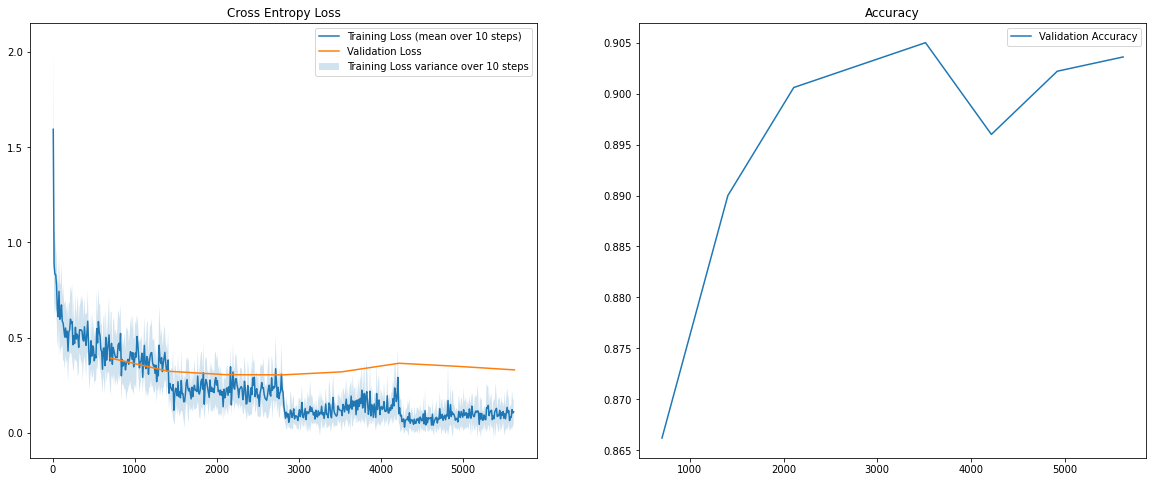

In [12]:
import pathlib
import matplotlib.pyplot as plt
import utils


plot_path = pathlib.Path("plots")
plot_path.mkdir(exist_ok=True)
# Save plots and show them
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.title("Cross Entropy Loss")
utils.plot_loss(trainer.train_history["loss"], label="Training Loss", npoints_to_average=10)
utils.plot_loss(trainer.validation_history["loss"], label="Validation Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.title("Accuracy")
utils.plot_loss(trainer.validation_history["accuracy"], label="Validation Accuracy")



plt.legend()
plt.savefig(plot_path.joinpath("task4a.png"))
plt.show()

In [13]:

print(compute_loss_and_accuracy(trainer.dataloader_test,model,trainer.loss_criterion))

(tensor(0.4194, device='cuda:0'), 0.8865)
